## K-Means Ingredient Clustering
Created by Aidan Boyne - see the [docs](https://github.com/aidanboyne/recipes).

In [3]:
import requests as rq
from lxml import html
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Import ingredient list from dataset: must run ingredientsNER.ipynb before first use to create set
ingredientSet = pd.read_csv(r'C:\Users\Aidan\Documents\GitHub\AR_scrape\ARScrape_Ingredients.csv')

In [5]:
#retrive page and load lmxl directory tree
# Ex: 258468 is valid, 258469

recipieNo = 265338
URL = "https://www.allrecipes.com/recipe/"+str(recipieNo)+"/"
page = rq.get(URL)
tree = html.fromstring(page.content)
page_omit_list = []

In [6]:
#Content Xpath mappings

count2Path = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[1]/div[2]/div[2]/ul/li[1]/a"
titlePath = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[1]/div[1]/div/h1"
ratingPath = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[1]/div[2]/div[1]/span"

#Data QC

valid = True #check if page contains real information
divno = 5 #flexible checker for different page layouts

#invalid recipie no
ratecount_str = tree.xpath(str(count2Path+"/text()"))

if not ratecount_str: #change if needed (i.e. < 5...)
    page_omit_list.append(recipieNo)
    print("Page does not exist, skipping...")
    valid = False
else:
    if ratecount_str[0] == ' Be the first to rate & review! ':
        ratecount = 0
    else:
        ratecount = int(''.join(x for x in ratecount_str[0] if x.isdigit()))
    #skips pages with no reviews as QC assurance, can change to vary confidence strictness
    if ratecount == 0: #change if needed (i.e. < 5...)
        page_omit_list.append(recipieNo)
        if valid:
            print("Page does not have enough reviews to be included in dataset, skipping...")
    else:
        #rating getter
        rating = float(tree.xpath(str(ratingPath+"/text()"))[0])
        #ingredient getter loop
        listing = 1
        ingno = 1
        first  = 1
        ingredients = []
        while listing:
            ingPath = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[2]/div[2]/div["+str(divno)+"]/section[1]/fieldset/ul/li["+str(ingno)+"]/label/span/span"
            newing = tree.xpath(str(ingPath+"/text()"))
            if not newing: #following checks for the two types of ingredient divs and switches to appropriate, also ends loop when no more ingredients
                if not ingredients:
                    divno = 6
                else:
                    listing = 0
            else:
                ingno = ingno + 1
                ingredients.append(newing[0])

        #direction getter loop (not needed for graph analysis, comment out)
        listing = 1
        dirno = 1
        directions = []
        while listing:
            directionPath = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[2]/div[2]/section[1]/fieldset/ul/li["+str(dirno)+"]/div[1]/div/p"
            newdir = tree.xpath(str(directionPath+"/text()"))
            dirno = dirno + 1
            if newdir == []:
                listing = 0;
            else:
                directions.append(newdir[0])        

        #Other variable assignments
        title = tree.xpath(str(titlePath+"/text()"))[0]

In [7]:
#Formatted display of title, rating, ingredients, and directions objects extracted

print(title+"\n-----------------------------")
print("Rating: "+str(rating)+"\n\nIngredients \n")
for ingredient in ingredients:
    print(" - "+ ingredient)
print("\nDirections")
for direction in directions:
    print(" - "+ direction)

Birria de Res Tacos (Beef Birria Tacos)
-----------------------------
Rating: 5.0

Ingredients 

 - 6 dried guajillo chile peppers, seeded 
 - 4 dried chile de arbol peppers, stemmed and seeded 
 - 2 dried ancho chiles, stemmed and seeded 
 - 1 tablespoon olive oil, or as needed 
 - 4 medium Roma tomatoes 
 - 2 tablespoons white vinegar 
 - 2 cloves garlic 
 - 2 teaspoons ground black pepper 
 - 4 whole cloves 
 - 1 pinch ground cinnamon 
 - 1 pinch ground cumin 
 - 1 pinch ground thyme 
 - 1 pinch dried marjoram 
 - 1 pinch dried oregano 
 - 1 pinch salt 

Directions
 - Preheat the oven to 325 degrees F (165 degrees C). Fill a pot with water and bring to a boil.
 - Start the sauce: Add guajillo, arbol, and ancho chile peppers to the boiling water; boil for 5 minutes. Remove pot from the heat and allow peppers to soak until cool. Drain, reserving 1/4 cup of the cooking water.
 - Meanwhile, sear the meat: Rinse beef and pat dry with paper towels. Cut beef into chunks if desired, and sea

In [8]:
print(ratecount_str)

[' 21 Ratings ']


In [9]:
# Checking each scraped ingredient one by one to see if it has word(s) containing master ingredient
# Longer whole-word substrings preferred to eliminate partial duplication and reduce lopsdd

complist=[]
extractIngredients = pd.DataFrame(ingredients, columns=['Extracted Ingredients']) #ingredients scraped
for setIngredient in ingredientSet['Ingredient']: #for each ingredient in the master list
    regex_str = "\\b" + setIngredient + "\\b"
    check = extractIngredients['Extracted Ingredients'].str.contains(pat=regex_str, case='False', na='False') #do ingredients scraped contain substring matching master
    if any(check):
        if setIngredient not in complist:
            complist.append(setIngredient)
complist = sorted([*set(complist)],key=len,reverse=True) #remove any duplicates due to substring matching and sort from longest to shortest

out = []
for s in complist:
    if not any([s in o for o in out]):
        out.append(s)
complist = out
print(complist)


['ground black pepper', 'ground cinnamon', 'chile de arbol', 'dried oregano', 'white vinegar', 'ground thyme', 'whole cloves', 'ground cumin', 'dried chile', 'olive oil', 'tomatoes', 'guajillo', 'marjoram', 'garlic', 'chiles', 'ancho', 'salt']


In [53]:
#TODO: loop through all recipies and perform comparison with linked rating, aggregate comparison/rating for analysis
#TODO: plot analysis to identify under-utilized combinations

## Functionized scraper and parser for looping
 - Input: pageNo (from loop)
 - Output:
    - If valid page --> `valid`: True (bool), `complist`: parsed ingredients (list), `rating`: AR rating (int)
    - If invalid --> `valid`: False (bool), `pageNo`: invalid page (int), `ratefail`: (bool)

In [107]:
def ar_scraper(pageNo):

    #import master ingredient list
    global ingredientSet
    #Page access URL
    URL = "https://www.allrecipes.com/recipe/"+str(pageNo)+"/"
    page = rq.get(URL)
    tree = html.fromstring(page.content)

    #Content Xpath mappings
    count2Path = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[1]/div[2]/div[2]/ul/li[1]/a"
    titlePath = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[1]/div[1]/div/h1"
    ratingPath = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[1]/div[2]/div[1]/span"

    #Data QC
    valid = True #check if page contains real information
    divno = 5 #flexible checker for different page layouts

    #invalid recipie no
    ratecount_str = tree.xpath(str(count2Path+"/text()"))

    if not ratecount_str: #change if needed (i.e. < 5...)
        #print("Page does not exist, skipping...")
        valid = False
        rate_fail = False
        #for main: if valid=False, add pageNo to pageOmitList
        return valid, pageNo, rate_fail
    else:
        if ratecount_str[0] == ' Be the first to rate & review! ':
            ratecount = 0
        else:
            ratecount = int(''.join(x for x in ratecount_str[0] if x.isdigit()))
        #skips pages with no reviews as QC assurance, can change to vary confidence strictness
        if ratecount == 0: #change if needed (i.e. < 5...)
            if valid:
                #print("Page does not have enough reviews to be included in dataset, skipping...")
                valid = False
                rate_fail = True
                #for main: if valid=False, add pageNo to pageOmitList
                return valid, pageNo, rate_fail
        else:
            #rating getter
            rating = float(tree.xpath(str(ratingPath+"/text()"))[0])
            #ingredient getter loop
            listing = 1
            ingno = 1
            first  = 1
            ingredients = []
            while listing:
                ingPath = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[2]/div[2]/div["+str(divno)+"]/section[1]/fieldset/ul/li["+str(ingno)+"]/label/span/span"
                newing = tree.xpath(str(ingPath+"/text()"))
                if not newing: #following checks for the two types of ingredient divs and switches to appropriate, also ends loop when no more ingredients
                    if not ingredients:
                        divno = 6
                    else:
                        listing = 0
                else:
                    ingno = ingno + 1
                    ingredients.append(newing[0])

            #---------------------------------------COMMENT OUT IN IMPLEMENTATION-----------------------------------------------
            # #direction getter loop (not needed for graph analysis)
            # listing = 1
            # dirno = 1
            # directions = []
            # while listing:
            #     directionPath = "/html/body/div[3]/div/main/div[1]/div[2]/div[1]/div[2]/div[2]/section[1]/fieldset/ul/li["+str(dirno)+"]/div[1]/div/p"
            #     newdir = tree.xpath(str(directionPath+"/text()"))
            #     dirno = dirno + 1
            #     if newdir == []:
            #         listing = 0;
            #     else:
            #         directions.append(newdir[0])        
            # #Other variable assignments
            # title = tree.xpath(str(titlePath+"/text()"))[0]
            #---------------------------------------END COMMENT OUT-------------------------------------------------------------

    if valid:

        #---------------------------------------COMMENT OUT IN IMPLEMENTATION-----------------------------------------------
        # #Formatted display of title, rating, ingredients, and directions objects extracted

        # print(title+"\n-----------------------------")
        # print("Rating: "+str(rating)+"\n\nIngredients \n")
        # for ingredient in ingredients:
        #     print(" - "+ ingredient)
        # print("\nDirections")
        # for direction in directions:
        #     print(" - "+ direction)
        #---------------------------------------END COMMENT OUT-------------------------------------------------------------

        # Checking each scraped ingredient one by one to see if it has word(s) containing master ingredient
        # Longer whole-word substrings preferred to eliminate partial duplication and reduce lopsdd
        complist=[]
        extractIngredients = pd.DataFrame(ingredients, columns=['Extracted Ingredients']) #ingredients scraped
        for setIngredient in ingredientSet['Ingredient']: #for each ingredient in the master list
            regex_str = "\\b" + setIngredient + "\\b"
            check = extractIngredients['Extracted Ingredients'].str.contains(pat=regex_str, case='False', na='False') #do ingredients scraped contain substring matching master
            if any(check):
                if setIngredient not in complist:
                    complist.append(setIngredient)
        complist = sorted([*set(complist)],key=len,reverse=True) #remove any duplicates due to substring matching and sort from longest to shortest

        out = []
        for s in complist:
            if not any([s in o for o in out]):
                out.append(s)
        complist = out
        return valid, complist, rating, ratecount

In [75]:
func_result = ar_scraper(258468)
print(func_result)

(True, ['ground black pepper', 'all-purpose flour', 'wide egg noodles', 'beef stew meat', 'chicken broth', 'dried thyme', 'sour cream', 'canola oil', 'mushrooms', 'soy sauce', 'garlic', 'onion', 'salt'], 4.4)


### TODO: Combination Architecture
- (DONE) Create list of all possible ingredient combinations from scraped ingredients
- (DONE) Create temporary dataframe from list to hold these results
- (DONE) Concatenate temp dataframe to master dataframe containing previous combos and ratings
- Change if/else loops to try/except to catch wider unavailibility
- Every 100 recipies, aggregate identical ingredient combinations in master dataframe by rating
- (DONE) Add weighting based on number of ratings to aggregation system
- Make API for website to access text file of allrecipies
- Find better weighting function

In [125]:
omitted_pages = []
masterframe = pd.DataFrame()
#Test Loop
for pageNumber in range(258468,258518):
    scraped=ar_scraper(pageNumber)
    if scraped[0]:
        print(pageNumber)
        combolist=list(itertools.combinations(scraped[1],2))
        comboframe = pd.DataFrame(list(itertools.combinations(scraped[1], 2)), columns=['Ingredient 1','Ingredient 2'])
        comboframe['Rating']= ([scraped[2]]*len(comboframe))
        comboframe['Weight']= ([scraped[3]]*len(comboframe))
        comboframe['Score'] = 100*comboframe.Rating+comboframe.Weight #Bad weighting function, fine-tune this later
        masterframe = pd.concat([masterframe, comboframe], axis=0, ignore_index=True)
    else:
        omitted_pages.append(scraped[1])
        print('Page Number: '+str(pageNumber)+ " was omitted.")

    #Aggregation every 100 entries
    if pageNumber%100 == 0:
        masterframe.reindex()
        masterframe.groupby(by=['Ingredient 1', 'Ingredient 2'])['Rating', 'Weight'].mean()

#Final aggregation before analysis
masterframe.reindex()
masterframe.groupby(by=['Ingredient 1', 'Ingredient 2'])['Rating', 'Weight'].mean()

print("Omitted Pages: ")
print(omitted_pages)
print("Non-aggregated Ingredient List")
print(masterframe)

258468
258469
Page Number: 258470 was omitted.
258471
258472
258473
258474
258475
258476
Page Number: 258477 was omitted.
Page Number: 258478 was omitted.
258479
258480
258481
258482
258483
258484
258485
258486
258487
258488
Page Number: 258489 was omitted.
258490
258491
258492
258493
258494
258495
258496


IndexError: list index out of range

In [126]:
masterframe.sort_values(by=['Score'], ascending=False)

,Ingredient 1,Ingredient 2,Rating,Weight,Score
0,ground black pepper,all-purpose flour,4.4,943,1383.0
50,dried thyme,sour cream,4.4,943,1383.0
57,sour cream,canola oil,4.4,943,1383.0
56,dried thyme,salt,4.4,943,1383.0
55,dried thyme,onion,4.4,943,1383.0
...,...,...,...,...,...
229,unsweetened cocoa powder,white sugar,3.0,2,302.0
228,unsweetened cocoa powder,chile powder,3.0,2,302.0
227,unsweetened cocoa powder,cayenne pepper,3.0,2,302.0
226,unsweetened cocoa powder,ground cinnamon,3.0,2,302.0


<AxesSubplot:xlabel='Rating', ylabel='Weight'>

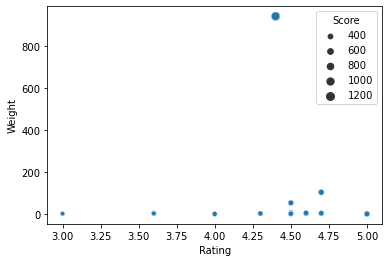

In [127]:
sns.scatterplot(data=masterframe, x="Rating", y="Weight", size="Score", legend=True)
